## Examen Parcial 1

**Nombre:** David L. Mejía<br>
**Fecha:** 24/09/2025<br>
**Git:** https://github.com/mcdavidleonardo/MachineLearning2/blob/master/examenRegresionLogistica.ipynb<br>

##### Predicción de Riesgo de Diabetes con **Regresión Logística** 
La diabetes es una enfermedad crónica que afecta a millones de personas en el mundo. El diagnóstico temprano es crucial para evitar complicaciones graves. En este ejercicio trabajaremso con un conjunto de datos de pacientes para predecir la probabilidad de que una persona tenga diabetes utilizando **Regresión Logística**
## **Dataset**
El archivo contien 15000 registros con las siguientes variables.<br>
1. Pregnancies: Número de embarazos (0 si es hombre).
2. PlasmaGlucose: Nivel de glucosa plasmática en ayunas (mg/dL).
3. DiastolicBloodPressure: Presión arterial diastólica (mmHg).
4. TricepsThickness: Espesor del pliegue cutáneo del tríceps (mm).
5. SerumInsulin: Concentración de insulina en suero (µU/mL).
6. BMI: Índice de masa corporal (kg/m²).
7. DiabetesPedigree: Factor hereditario de riesgo de diabetes.
8. Age: Edad del paciente (años).
9. Diabetic: Variable objetivo (0 = No diabético, 1 = Diabético).
# Instrucciones
Desarrolle el ejercicio paso a paso en un notebook de Jupyter siguiendo las indicaciones:<br>
1. **Lectura y exploración inicial del dataset**
    * Importe el archivo diabetes.csv.
    * Muestre dimensiones, nombres de columnas y distribución de clases.
    * Verifique valores nulos o inconsistencias.
2. **Análisis exploratorio de datos (EDA)**
    * Genere estadísticas descriptivas de las variables numéricas.
    * Dibuje histogramas para al menos 3 variables.
    * Construya la matriz de correlación entre las variables predictoras.
3. **Preparación del dataset**
    * Elimine columnas irrelevantes (ejemplo: PatientID).
    * Divida el dataset en entrenamiento (80%) y prueba (20%) de manera estratificada.
4. **Construcción del modelo**
    * Defina un Pipeline con:
        * StandardScaler para normalizar los datos.
        * LogisticRegression con max_iter=500.
    * Realice validación cruzada (k=5) en el conjunto de entrenamiento.
    * Reporte el AUC-ROC y el AUC-PR de la validación cruzada.
5. **Evaluación del modelo en el conjunto de prueba**
    * Calcule las probabilidades de pertenecer a la clase diabético.
    * Genere la matriz de confusión y el reporte de clasificación.
    * Calcule las métricas: AUC-ROC, AUC-PR, Brier Score.
    * Dibuje las curvas ROC, Precision-Recall y de calibración.    
6. **Selección de umbral**
    * Construya una tabla de métricas para diferentes umbrales (de 0.1 a 0.9).
    * Determine el mejor umbral según el índice de Youden J.
    * Discuta cómo cambia la sensibilidad y la especificidad al modificar el umbral.    
7. **Interpretación del modelo**
    * Liste los coeficientes de la regresión logística.
    * Calcule los odds ratios e interprete al menos dos variables clave.
    * Ejemplo: “Un aumento de 1 unidad en PlasmaGlucose incrementa en X veces la probabilidad de diabetes”.
8. **Predicción con nuevos pacientes**
   * Ingrese manualmente los datos de 2 pacientes ficticios.
   * Calcule la probabilidad de diabetes y la clasificación final para cada u

In [1]:
# ==== Importar librerías y configurar entorno ====
# Muestra el gráfico en la misma celda
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para dividir los datos en entrenamiento/test y evaluar
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
# Sirve para encadenar pasos
from sklearn.pipeline import Pipeline
# Para poner en una escala comparable a las columnas numéricas
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# Para evaluar(medir) si el modelo esta funcionando bien
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report,
    brier_score_loss, precision_score, recall_score, accuracy_score
)
# Para usar funcionalidad de calibración
from sklearn.calibration import calibration_curve

# Dar estilos a los gráficos
sns.set(style="whitegrid", palette="muted", context="notebook")
# Para que la aleatoriedad al mezclar datos sea consistente
RND = 42

## 1. Lectura y exploración inicial del dataset

In [2]:
# Intento 1: separador por defecto (',')
# df = pd.read_csv("D:/temp/datasets/diabetes.csv")
# Si todo vino en una sola columna, re-leer con ';'
df = pd.read_csv("D:/temp/datasets/diabetes.csv", sep=";")
# Se lee el archivo diabetes.csv


# Se presenta las dimensiones (filas/columnas) del dataframe
print("Dimensiones:", df.shape)
# Se presenta el nombre de las columnas del dataframe
print("\nColumnas:", df.columns.tolist())
# Se imprime los primeros 5 registros
display(df.head())

# Se verifica valores nulos
print("\nValores nulos por columna:")
display(df.isnull().sum())

Dimensiones: (15000, 10)

Columnas: ['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age', 'Diabetic']


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0



Valores nulos por columna:


PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

## 1.1. Limpieza mínima y verificación de clases

In [3]:
# Comprobamos que la columna objetivo exista "Diabetic"
if 'Diabetic' not in df.columns:
    raise ValueError("La columna no existe. Verifique el archivo.")
else:
    print("La columna si existe.")

# Eliminamos ID si existe
# Se elimina columna PatientID
id_col = [c for c in df.columns if c in ('PatientID')]
if id_col:
    df.drop(columns=id_col, inplace=True)
    print("Columna ID eliminada")
else:
    print("No se encontró la columna.")
    
# Tipos y valores faltantes
print("\nTipos de datos:")
display(df.dtypes)

print("\nValores faltantes por columna:")
display(df.isnull().sum())

# Distribución de clases
print("\nDistribución de clases (Diabetic):")
print("Conteo absoluto:")
display(df['Diabetic'].value_counts())

La columna si existe.
Columna ID eliminada

Tipos de datos:


Pregnancies                 int64
PlasmaGlucose               int64
DiastolicBloodPressure      int64
TricepsThickness            int64
SerumInsulin                int64
BMI                       float64
DiabetesPedigree          float64
Age                         int64
Diabetic                    int64
dtype: object


Valores faltantes por columna:


Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64


Distribución de clases (Diabetic):
Conteo absoluto:


Diabetic
0    10000
1     5000
Name: count, dtype: int64

## 2. Análisis exploratorio de datos (EDA)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,15000.0,3.224533,3.391020,0.000000,0.000000,2.000000,6.000000,14.000000
PlasmaGlucose,15000.0,107.856867,31.981975,44.000000,84.000000,104.000000,129.000000,192.000000
DiastolicBloodPressure,15000.0,71.220667,16.758716,24.000000,58.000000,72.000000,85.000000,117.000000
TricepsThickness,15000.0,28.814000,14.555716,7.000000,15.000000,31.000000,41.000000,93.000000
SerumInsulin,15000.0,137.852133,133.068252,14.000000,39.000000,83.000000,195.000000,799.000000
BMI,15000.0,31.509646,9.759000,18.200512,21.259887,31.767940,39.259692,56.034628
DiabetesPedigree,15000.0,0.398968,0.377944,0.078044,0.137743,0.200297,0.616285,2.301594
Age,15000.0,30.137733,12.089703,21.000000,22.000000,24.000000,35.000000,77.000000
Diabetic,15000.0,0.333333,0.471420,0.000000,0.000000,0.000000,1.000000,1.000000


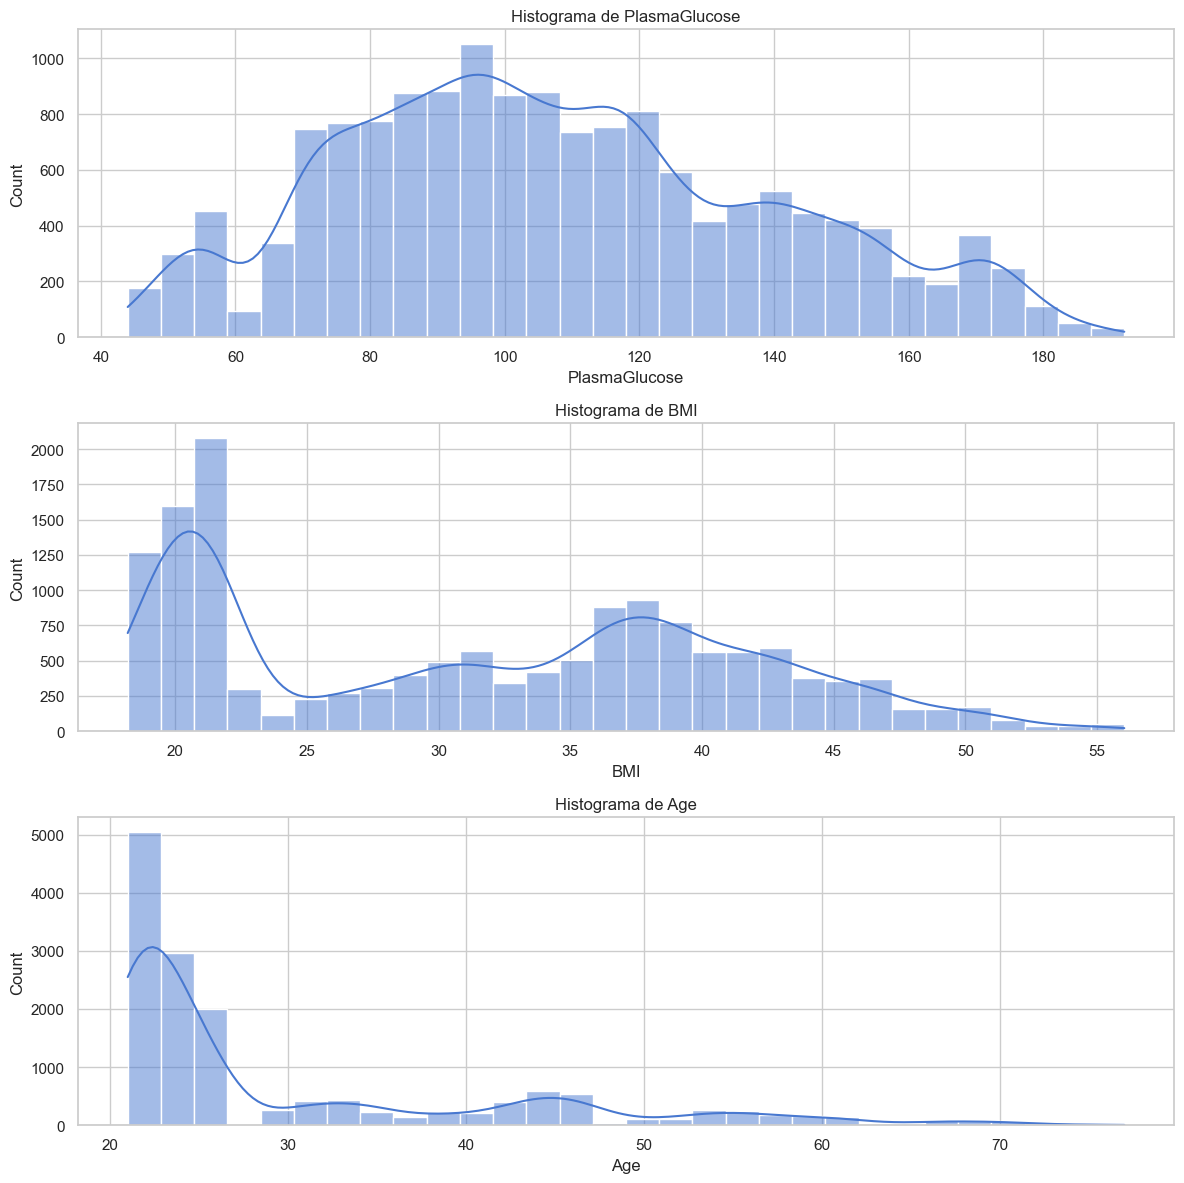

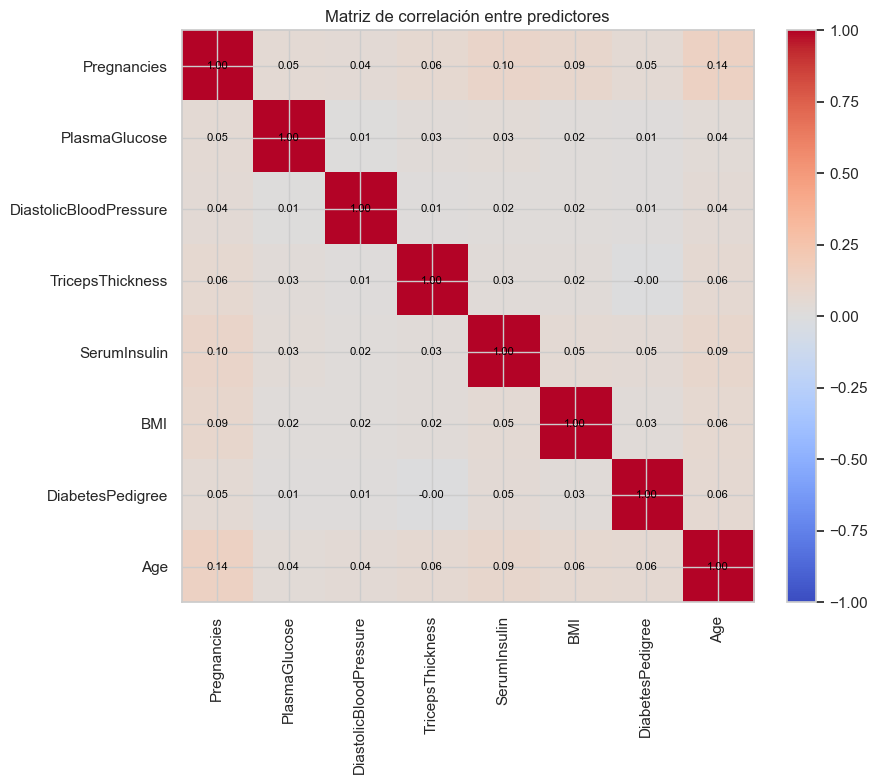

In [4]:
# Estadísticas descriptivas para poder detectar valores no válidos o extremos que podría afectar al modelo
# Contador, promedio, desviación, mínimos, máximos, percentiles
display(df.describe().T)

# Lista para histograma simple para BMI
vars_to_hist = []
# Se valida que columnas existan
for v in ['PlasmaGlucose', 'BMI', 'Age']:
    if v in df.columns:
        vars_to_hist.append(v)
        
# Se dibuja el histograma (Tomado de IA)
# Histograma con 30 bins y curva kde encima
# dropna evita que valores faltantes dañen la curva
# Ayuda a decidir si se necesita limpiar datos o transformar alguna variable. Si una variable esta muy sesgada o tiene valores raros
plt.figure(figsize=(12, 4 * len(vars_to_hist)))
for i, col in enumerate(vars_to_hist, 1):
    plt.subplot(len(vars_to_hist), 1, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Histograma de {col}')
plt.tight_layout()
plt.show()

# Matriz de correlación - la variable predictora es Diabetic (Tomado de IA)
# Se analiza que tan relacionadas estan las columnas entre si
# Muestra matriz como mapa de calor con colores que van de azul (-1) a rojo (1)
predictors = df.drop(columns=['Diabetic'], errors='ignore').select_dtypes(include=[np.number]).columns
corr = df[predictors].corr()
plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Se añade barra de color
plt.colorbar(im, fraction=0.046, pad=0.04)

# Se añade etiquetas
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.yticks(range(len(predictors)), predictors)

# Se muestran valores de cada celda
for i in range(len(predictors)):
    for j in range(len(predictors)):
        text = f"{corr.iloc[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=8)

plt.title("Matriz de correlación entre predictores")
plt.tight_layout()
plt.show()

## 3. Preparación del dataset

In [5]:
# La columna PatientID ya se elimina en 1.1
# Se separa eje X y eje y en variables
X = df.drop(columns=['Diabetic'])
y = df['Diabetic']

# Se divide entrenamiento (80%) y prueba (20%)
# stratity mantiene misma proporción de casos con o sin diabetes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)
print("Tamaños: X_train", X_train.shape, "X_test", X_test.shape)


Tamaños: X_train (12000, 8) X_test (3000, 8)


## 4. Construcción del modelo

In [6]:
# (Tomado de IA)
# Se crea el pipeline con StandardScaler y un modelo de regresión logística (LogisticRegression).
# Pipeline es una secuencia de pasos (instrucciones)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandariza cada columna numérica (media 0, desviación 1)
    ('logreg', LogisticRegression(max_iter=500, random_state=RND)) # Modelo de regresión
])

# Se crea el esquema de validación cruzada estratificada con 5 pliegues
# Valida/repite el proceso 5 veces con la misma proporción de personas con/sin diabetes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
scoring = {'roc_auc':'roc_auc', 'avg_prec':'average_precision'}

# Se evalúa el modelo utilizando validación cruzada y se almacenan las métricas de rendimiento (ROC-AUC y AUC-PR).
# ROC-AUC --> qué tan bien el modelo ordena a las personas con mayor probabilidad de diabetes por encima de las que no la tienen.
# Average Precision (AUC-PR) --> se centra en precisión y cobertura, útil si hay menos casos positivos.
# Valores más cercanos a 1 son mejores. La desviación estándar indica qué tan consistentes son los resultados entre pliegues.
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=cv,
    scoring=scoring, return_train_score=False, n_jobs=-1
)

# Presenta promedio/desviación estandar
print("Validación cruzada (5 folds):")
print(f"ROC-AUC (mean ± std): {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"AUC-PR (average precision) (mean ± std): {cv_results['test_avg_prec'].mean():.4f} ± {cv_results['test_avg_prec'].std():.4f}")

Validación cruzada (5 folds):
ROC-AUC (mean ± std): 0.8578 ± 0.0059
AUC-PR (average precision) (mean ± std): 0.7429 ± 0.0188


## 5. Evaluación del modelo en el conjunto de prueba

In [7]:
# Se entrena el modelo completo
# Modelo “aprende” la relación entre variables (glucosa, IMC, edad, etc.) y el resultado (diabetes sí/no)
# usando solo los datos de entrenamiento.
pipeline.fit(X_train, y_train)

# Se arma las probabilidades y predicciones con umbral por defecto 0.5
# 0.5 neutral, > 0.5 diabético, < 0.5 no diabético
# Modelo entrega nivel de riesgo entre 0 y 1 (0-No diabético; 1-Diabético)
y_prob = pipeline.predict_proba(X_test)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

# Matriz de confusión (Tomado de IA)
# Compara valor real con valor de predicción
cm = confusion_matrix(y_test, y_pred_05)
print("Matriz de confusión (umbral 0.5):")
display(pd.DataFrame(cm, index=['No diabético (verdadero)', 'Diabético (verdadero)'],
                     columns=['Predicción No', 'Predicción Sí']))

# Reporte de clasificación (Tomado de IA)
# Precisión, de Si que proporpción es
# Recall(Sensibilidad), cuales son Si de verdad
# F1, equilibrio entre precisión y recall
print("\nReporte de clasificación (umbral 0.5):")
print(classification_report(y_test, y_pred_05, digits=4))

# Métricas: AUC-ROC, AUC-PR, Brier Score
# AUC-ROC mide qué tan bien ordena a los pacientes de mayor a menor riesgo sin fijar un umbral. Más cerca de 1 es mejor
# AUC-PR enfoca el rendimiento en la clase Diabéticos
# Brier Score, compara la probabilidad que da el modelo con la realidad. Más bajo es mejor
auc_roc = roc_auc_score(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
brier = brier_score_loss(y_test, y_prob)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR (Average Precision): {auc_pr:.4f}")
print(f"Brier score: {brier:.4f}")

Matriz de confusión (umbral 0.5):


,Predicción No,Predicción Sí
No diabético (verdadero),1769,231
Diabético (verdadero),404,596



Reporte de clasificación (umbral 0.5):
              precision    recall  f1-score   support

           0     0.8141    0.8845    0.8478      2000
           1     0.7207    0.5960    0.6524      1000

    accuracy                         0.7883      3000
   macro avg     0.7674    0.7402    0.7501      3000
weighted avg     0.7829    0.7883    0.7827      3000

AUC-ROC: 0.8554
AUC-PR (Average Precision): 0.7455
Brier score: 0.1442


## 5.1. Curvas ROC y Precision-Recall

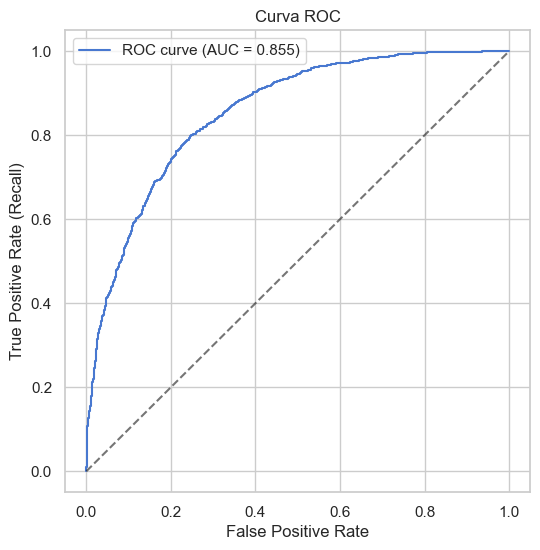

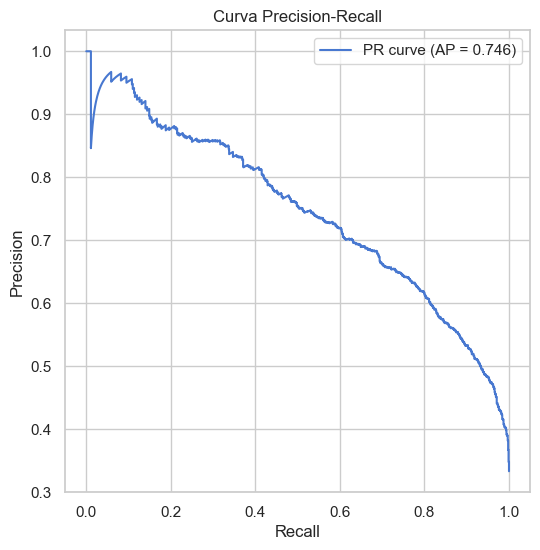

In [8]:
# fpr = tasa de falsos positivos
# tpr = tasa de verdaderos positivos (recall)
# roc_thresh = umbrales usados
# Muestra el intercambio entre “detectar más diabéticos” (recall alto) y
# “no dar falsas alarmas” (falsos positivos bajos) según se mueve el umbral

# Es como ajustar la sensibilidad de un detector. Si se calibra muy sensible, detecta casi todo (alto recall)
# pero suena más veces por error (más falsos positivos).
# ROC (Tomado de IA)
fpr, tpr, roc_thresh = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

# Enfoca el rendimiento sobre la clase diabéticos.
# Muestra cómo al intentar atrapar más casos (subir recall), normalmente se sacrifica precisión (más falsas alarmas).
# PR (Tomado de IA)
precision, recall, pr_thresh = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'PR curve (AP = {auc_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

## 5.2. Calibración

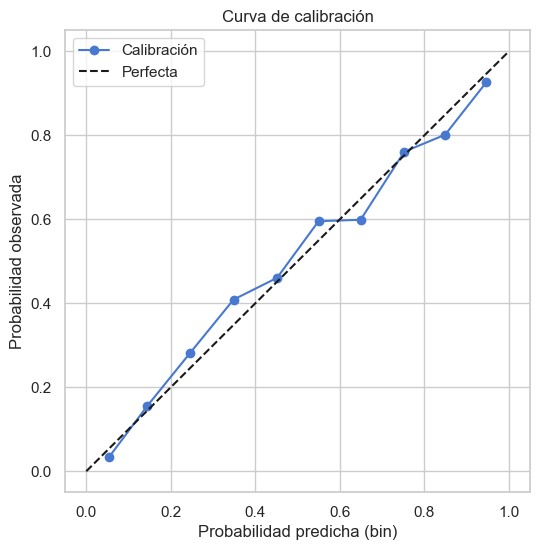

In [9]:
# Esta curva evalúa qué tan veridicas son las probabilidades del modelo.
# Analogía: pronóstico del tiempo; si dice 30% de lluvia, debería llover ~30% de las veces en situaciones similares.
# Si los puntos están cerca de la diagonal, las probabilidades son confiables.
# Por debajo de la diagonal, el modelo es sobreconfiado (predice riesgos mayores de los que ocurren).
# Por encima de la diagonal, es conservador (predice riesgos menores de los que ocurren).
# Ayuda a decidir que umbral tomar

# Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibración')
plt.plot([0,1],[0,1], 'k--', label='Perfecta')
plt.xlabel('Probabilidad predicha (bin)')
plt.ylabel('Probabilidad observada')
plt.title('Curva de calibración')
plt.legend()
plt.grid(True)
plt.show()

## 6. Selección de umbral

In [10]:
# (Tomado de IA)
# Sensibilidad (recall), qué proporción de diabéticos se detecta
# Especificidad, qué proporción de no diabéticos se deja pasar sin alarma
# Precisión, de los que se marca como diabéticos, cuántos realmente lo son.
# Exactitud: aciertos totales.

# Lista para diferentes umbrales (de 0.1 a 0.9).
thresholds = np.arange(0.1, 0.91, 0.1)
rows = []
for th in thresholds:
    y_pred_th = (y_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_th).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0  # sensibilidad (recall)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0  # especificidad
    prec = precision_score(y_test, y_pred_th, zero_division=0)
    acc = accuracy_score(y_test, y_pred_th)
    youden = sens + spec - 1
    rows.append({'threshold': th, 'tp':tp, 'fp':fp, 'tn':tn, 'fn':fn,
                 'sensitivity': sens, 'specificity': spec, 'precision': prec,
                 'accuracy': acc, 'youden_J': youden})

th_df = pd.DataFrame(rows).set_index('threshold')
display(th_df)

# Mejor umbral por Youden J
# Busca un punto de equilibrio entre detectar casos y evitar falsas alarmas
best_th = th_df['youden_J'].idxmax()
print(f"Mejor umbral según Youden J: {best_th} (Youden = {th_df.loc[best_th,'youden_J']:.4f})")

# Cambio de sensibilidad
display(th_df.loc[[best_th, 0.5]])


,tp,fp,tn,fn,sensitivity,specificity,precision,accuracy,youden_J
threshold,,,,,,,,,
0.1,971,1201,799,29,0.971,0.3995,0.447053,0.590000,0.3705
0.2,882,719,1281,118,0.882,0.6405,0.550906,0.721000,0.5225
0.3,789,483,1517,211,0.789,0.7585,0.620283,0.768667,0.5475
0.4,695,347,1653,305,0.695,0.8265,0.666987,0.782667,0.5215
0.5,596,231,1769,404,0.596,0.8845,0.720677,0.788333,0.4805
0.6,465,142,1858,535,0.465,0.9290,0.766063,0.774333,0.3940
0.7,371,79,1921,629,0.371,0.9605,0.824444,0.764000,0.3315
0.8,250,41,1959,750,0.250,0.9795,0.859107,0.736333,0.2295
0.9,125,10,1990,875,0.125,0.9950,0.925926,0.705000,0.1200


Mejor umbral según Youden J: 0.30000000000000004 (Youden = 0.5475)


,tp,fp,tn,fn,sensitivity,specificity,precision,accuracy,youden_J
threshold,,,,,,,,,
0.3,789,483,1517,211,0.789,0.7585,0.620283,0.768667,0.5475
0.5,596,231,1769,404,0.596,0.8845,0.720677,0.788333,0.4805


## 7. Interpretación del modelo

In [11]:
# (Tomado de IA)
# ODDS --> Tendencia a ser diabético

# Recuperar coeficientes de la regresión logística entrenada
scaler = pipeline.named_steps['scaler']
logreg = pipeline.named_steps['logreg']

# Coeficientes con los nombres de las características
feat_names = X.columns.tolist()
coefs = logreg.coef_[0]
coef_table = pd.DataFrame({
    'feature': feat_names,
    'coef_scaled': coefs,
    'odds_ratio_per_std': np.exp(coefs)  # OR por 1 desviación estándar
}).set_index('feature').sort_values(by='coef_scaled', key=lambda x: x.abs(), ascending=False)

# OR por unidad original (exp(coef_scaled / scale))
# Nota: StandardScaler: z = (x - mean) / scale -> cambio 1 unidad en x -> cambio 1/scale en z
or_per_unit = np.exp(coefs / scaler.scale_)
coef_table['odds_ratio_per_unit'] = or_per_unit

display(coef_table)

# Interpretación textual de al menos 2 variables clave (ejemplo: PlasmaGlucose y BMI, si existen)
for var in ['PlasmaGlucose', 'BMI']:
    if var in feat_names:
        or_std = coef_table.loc[var, 'odds_ratio_per_std']
        or_unit = coef_table.loc[var, 'odds_ratio_per_unit']
        print(f"\nInterpretación para {var}:")
        print(f"  - OR por 1 desviación estándar (exp(coef)): {or_std:.3f}.")
        print(f"    -> Un aumento de 1 desviación estándar en {var} multiplica las odds de diabetes por {or_std:.3f}.")
        print(f"  - OR por 1 unidad original (exp(coef/scale)): {or_unit:.3f}.")
        print(f"    -> Un aumento de 1 unidad en {var} (p.ej. +1 mg/dL en PlasmaGlucose) cambia las odds por un factor de {or_unit:.3f}.")


,coef_scaled,odds_ratio_per_std,odds_ratio_per_unit
feature,,,
Pregnancies,0.921006,2.511815,1.312212
Age,0.697250,2.008223,1.009318
SerumInsulin,0.510625,1.666332,1.012079
BMI,0.499743,1.648298,1.023714
DiabetesPedigree,0.379139,1.461027,1.003817
TricepsThickness,0.340428,1.405549,1.052531
PlasmaGlucose,0.296551,1.345212,2.728475
DiastolicBloodPressure,0.201298,1.222989,1.059193



Interpretación para PlasmaGlucose:
  - OR por 1 desviación estándar (exp(coef)): 1.345.
    -> Un aumento de 1 desviación estándar en PlasmaGlucose multiplica las odds de diabetes por 1.345.
  - OR por 1 unidad original (exp(coef/scale)): 2.728.
    -> Un aumento de 1 unidad en PlasmaGlucose (p.ej. +1 mg/dL en PlasmaGlucose) cambia las odds por un factor de 2.728.

Interpretación para BMI:
  - OR por 1 desviación estándar (exp(coef)): 1.648.
    -> Un aumento de 1 desviación estándar en BMI multiplica las odds de diabetes por 1.648.
  - OR por 1 unidad original (exp(coef/scale)): 1.024.
    -> Un aumento de 1 unidad en BMI (p.ej. +1 mg/dL en PlasmaGlucose) cambia las odds por un factor de 1.024.


## 8. Predicción con nuevos pacientes

In [12]:
# Ingreso de datos por teclado
print("Ingrese los datos de 2 pacientes para predecir el riesgo de diabetes:\n")

# Crear lista de características (según columnas de X usadas en el modelo)
columnas = X.columns.tolist()
pacientes = []

# Dos pacientes
for p in range(2):
    print(f"\n--- Paciente {p+1} ---")
    paciente = {}
    for f in columnas:
        val = float(input(f"Ingrese valor para {f}: "))
        paciente[f] = val
    pacientes.append(paciente)

# Convertir a DataFrame
df_new = pd.DataFrame(pacientes)

# Calcular probabilidades y predicciones
# Se usa umbral 0.5
y_prob_new = pipeline.predict_proba(df_new)[:, 1]
y_pred_new = (y_prob_new >= 0.5).astype(int)

# Mostrar resultados
results = df_new.copy()
results['Probabilidad_Diabetes'] = y_prob_new
results['Predicción (0=No, 1=Sí)'] = y_pred_new

print("\nResultados de predicción para pacientes ingresados:")
display(results)

Ingrese los datos de 2 pacientes para predecir el riesgo de diabetes:


--- Paciente 1 ---


Ingrese valor para Pregnancies:  6
Ingrese valor para PlasmaGlucose:  180
Ingrese valor para DiastolicBloodPressure:  85
Ingrese valor para TricepsThickness:  35
Ingrese valor para SerumInsulin:  200
Ingrese valor para BMI:  36.2
Ingrese valor para DiabetesPedigree:  1.2
Ingrese valor para Age:  55



--- Paciente 2 ---


Ingrese valor para Pregnancies:  3
Ingrese valor para PlasmaGlucose:  130
Ingrese valor para DiastolicBloodPressure:  78
Ingrese valor para TricepsThickness:  25
Ingrese valor para SerumInsulin:  100
Ingrese valor para BMI:  30.5
Ingrese valor para DiabetesPedigree:  0.6
Ingrese valor para Age:  42



Resultados de predicción para pacientes ingresados:


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Probabilidad_Diabetes,"Predicción (0=No, 1=Sí)"
0,6.0,180.0,85.0,35.0,200.0,36.2,1.2,55.0,0.969157,1
1,3.0,130.0,78.0,25.0,100.0,30.5,0.6,42.0,0.457004,0
